In [27]:
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors

In [28]:
DRAG_COEF = 0.2
WATER_VOL_PENETRATED = 0
WATER_INERTIA = 1
GRAV_CONST = 10
RAIN_INTENSITY = 0.8

INFILTRATION_RATE_C = 1
DECAY_C = 0.1

TIME = 0
RAIN_VAR = 0

In [29]:

im = Image.open("cdne43h.tif")
npim = np.array(im)[:, :]  # , np.newaxis]
npim = npim[900:1200, 700:1000]
PIL_image = Image.fromarray(npim).convert("L")
# PIL_image.show()
# plt.imshow(npim,norm=colors.LogNorm())
# plt.show()
# im.show()

In [30]:
INFO_MATRIX = np.array(
    [
        np.array(npim),
        ["penetrability"],
        ["blockage"],
        ["channel_cross_section"],
    ],
    dtype=object,
)

Y, X = INFO_MATRIX[0].shape


# np.array([[y_grad],[x_grad]])
GRADIENT = np.flip(np.array(np.gradient(INFO_MATRIX[0])), axis=0)

# underground, startx, starty, endx, endy, max_intake_rate, curr_intake_rate
CHANNELS = np.array([])

# y, x, vy, vx, in_channel
WATER_UNITS = np.array([[i // Y, i % X, 0, 0, 0] for i in range(X * Y)])
LEN_ELE = len(WATER_UNITS[0])

UNIT_RAIN = np.array([[i // Y, i % X, 0, 0, 0] for i in range(X * Y)])


def rain():
    global RAIN_VAR, WATER_UNITS

    RAIN_VAR += RAIN_INTENSITY

    if RAIN_VAR >= 1:
        for _ in range(int(RAIN_VAR)):
            WATER_UNITS = np.append(WATER_UNITS, UNIT_RAIN, axis=0)
        RAIN_VAR = 0


def slope_flow():
    global WATER_UNITS

    # For moving water
    WATER_UNITS[:, :2] += WATER_UNITS[:, 2:4]

    deleter_arr = []
    for n, i in enumerate(WATER_UNITS):
        if i[0] < 0 or i[1] < 0 or i[0] >= Y or i[1] >= X:
            deleter_arr.append(n)


    WATER_UNITS = np.delete(WATER_UNITS, (deleter_arr), 0)

    # For accelerating water

    temp_grad = GRADIENT[:, WATER_UNITS[:, 0], WATER_UNITS[:, 1]]



    WATER_UNITS[:, 2:4] += (
        GRAV_CONST
        * np.transpose(
            np.multiply(
                temp_grad,
                np.transpose(
                    np.sin(
                        2
                        * np.arctan(
                            np.sqrt(np.sum(np.multiply(temp_grad, temp_grad), axis=0))
                        )
                    )
                ),
            )
        )
        - DRAG_COEF * WATER_UNITS[:, 2:4]
    ).astype(np.int32)


def channel_flow():
    pass


def percolator():
    global WATER_VOL_PENETRATED, INFILTRATION_RATE_C, WATER_UNITS, DECAY_C, Y, X
    N = WATER_UNITS.shape[0]
    to_percolate = random.choices(range(N), k=int(Y*X * INFILTRATION_RATE_C))
    WATER_VOL_PENETRATED += len(to_percolate)
    WATER_UNITS = np.delete(WATER_UNITS, to_percolate, axis=0)
    INFILTRATION_RATE_C /= np.exp(DECAY_C)
    # print(WATER_UNITS.shape)


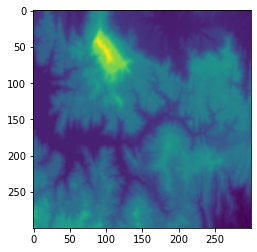

In [31]:
plt.imshow(npim)

99	597256

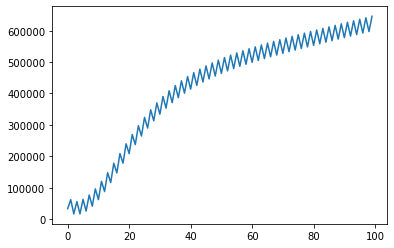

In [32]:
water_in_system = []
for i in range(100):
    print(f'\r{i}\t{len(WATER_UNITS)}', end='')
    rain()
    slope_flow() 
    percolator()
    water_in_system.append(len(WATER_UNITS))
plt.plot(water_in_system)

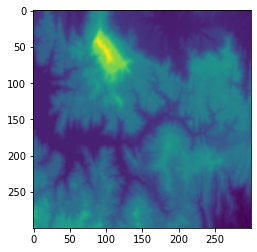

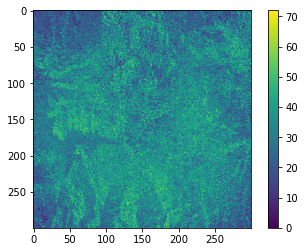

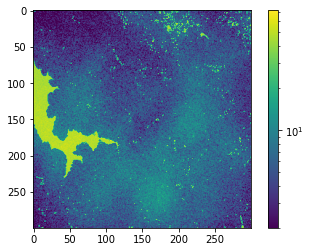

In [33]:
velocity_map = np.zeros(shape=(Y,X))
intensiy_map = np.zeros(shape=(Y,X))
for i in range(len(WATER_UNITS)):
    vel = np.linalg.norm(WATER_UNITS[i, 2:4])
    [y, x] = WATER_UNITS[i, 0:2]
    velocity_map[y,x] = max(velocity_map[y,x], vel)
    intensiy_map[y,x] += 1

plt.imshow(npim)
plt.show()    

plt.imshow(velocity_map)
plt.colorbar()
plt.show()
    
plt.imshow((intensiy_map + 1), norm=colors.LogNorm())
plt.colorbar()
plt.show()

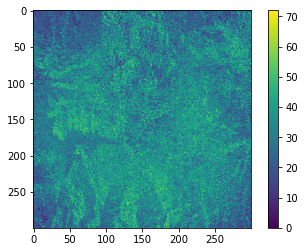

In [34]:

plt.imshow(velocity_map)
plt.colorbar()
plt.show()